- Try to peak analysis instead to filter the neurons
- First filter by comparison with spike shuffle data
- Separate track into outbound and homebound zone
- Use new ramp score
- Only perform analysis on Sarah's cell

In [1]:
%reload_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('..')
os.environ['MPLCONFIGDIR'] = '../config'
import pickle
import pandas as pd
import sklearn as sk
from sklearn.decomposition import *
from sklearn.cluster import *
import numpy as np
import matplotlib.pylab as plt
from matplotlib.backends.backend_pdf import PdfPages
from analysis.sparse_analysis import *
import sklearn.metrics as skmetrics
from scipy.stats import pearsonr, wilcoxon
from scipy import signal
from palettable.colorbrewer.qualitative import Paired_8 as colors
np.random.seed(0) #for reproducibility
import matplotlib as mpl
from analysis.peak_detect import *
import pickle
import pandas as pd 
import seaborn as sns
sns.set_palette("Accent")

/home/teristam/miniconda3/envs/glm_mec_model/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data

In [2]:
base_path = '/mnt/datastore/Teris/CurrentBiology_2022/'
df_lm = pd.read_pickle(base_path + 'df_lm.pkl')
df_rampscore = pd.read_pickle(base_path+'all_rampscore.pkl')
df_shuffle = pd.read_pickle(base_path+'all_mice_concatenated_shuffle_data_rewarded_unsmoothened.pkl')
df_lm = pd.read_pickle(base_path+'df_lm_merge.pkl')

In [3]:
# filter the cells
df_shuffle2 = df_shuffle[['session_id','cluster_id','shuffle_id', 'beaconed_map']].copy()
# # only included curated cell
session_id_sel = df_lm.session_id.unique()
df_shuffle2 = df_shuffle2[df_shuffle2.session_id.isin(session_id_sel)]



Data cleaning

In [5]:
# Load average shuffled firing rate
df_shuffle2['trial_type'] = 'shuffle'
df_shuffle2.rename(columns={'beaconed_map': 'fr_smooth'},inplace=True)

## average the firing rate to 2cm per bin
def average_fr(x):
    x = np.array(x).reshape(100,-1).mean(axis=1)
    return x
    
df_shuffle2['fr_smooth'] = df_shuffle2.fr_smooth.apply(average_fr)
df_shuffle2['pos'] = [np.arange(0,200,2)-30]*len(df_shuffle2) #track starts at -30
df_shuffle2

,session_id,cluster_id,shuffle_id,fr_smooth,trial_type,pos
0,245_D18_2018-11-10_11-07-50,9,0,"[10.257548911029332, 9.005811124250048, 8.0352...",shuffle,"[-30, -28, -26, -24, -22, -20, -18, -16, -14, ..."
1,245_D18_2018-11-10_11-07-50,9,1,"[7.470128722618455, 8.304828753052169, 6.00084...",shuffle,"[-30, -28, -26, -24, -22, -20, -18, -16, -14, ..."
2,245_D18_2018-11-10_11-07-50,9,2,"[20.05740121618787, 10.240248850141658, 8.9401...",shuffle,"[-30, -28, -26, -24, -22, -20, -18, -16, -14, ..."
3,245_D18_2018-11-10_11-07-50,9,3,"[9.755726137267011, 9.738912675816838, 10.1504...",shuffle,"[-30, -28, -26, -24, -22, -20, -18, -16, -14, ..."
4,245_D18_2018-11-10_11-07-50,9,4,"[9.180815637396716, 10.06239830423924, 11.6186...",shuffle,"[-30, -28, -26, -24, -22, -20, -18, -16, -14, ..."
...,...,...,...,...,...,...
900995,M7_D6_2020-11-05_16-26-28,31,995,"[12.256067086763135, 17.952046776714724, 18.82...",shuffle,"[-30, -28, -26, -24, -22, -20, -18, -16, -14, ..."
900996,M7_D6_2020-11-05_16-26-28,31,996,"[14.496448683336155, 15.065261045367851, 13.92...",shuffle,"[-30, -28, -26, -24, -22, -20, -18, -16, -14, ..."
900997,M7_D6_2020-11-05_16-26-28,31,997,"[13.317327643465944, 13.721697613615953, 16.67...",shuffle,"[-30, -28, -26, -24, -22, -20, -18, -16, -14, ..."
900998,M7_D6_2020-11-05_16-26-28,31,998,"[8.977036806112254, 16.304051830507195, 18.820...",shuffle,"[-30, -28, -26, -24, -22, -20, -18, -16, -14, ..."


In [6]:
# merge with the original
df_fr = df_rampscore[['session_id', 'cluster_id', 'ramp_region','trial_type','fr_smooth']]
df_fr = df_fr[df_fr.ramp_region == 'all'] # get the full firing rate curve
df_fr.drop(columns='ramp_region',inplace=True)
pos = np.arange(0,200,2)-30
df_fr['pos'] = [np.arange(0,200,2)-30]*len(df_fr)

df_merged = pd.concat([df_fr, df_shuffle2],axis=0)
df_merged

,session_id,cluster_id,trial_type,fr_smooth,pos,shuffle_id
8,245_D18_2018-11-10_11-07-50,9,beaconed,"[37.076238161899354, 40.022302504599494, 42.96...","[-30, -28, -26, -24, -22, -20, -18, -16, -14, ...",NaN
9,245_D18_2018-11-10_11-07-50,9,non-beaconed,NaN,"[-30, -28, -26, -24, -22, -20, -18, -16, -14, ...",NaN
10,245_D18_2018-11-10_11-07-50,9,probe,"[49.68186442140235, 51.474931113789616, 53.267...","[-30, -28, -26, -24, -22, -20, -18, -16, -14, ...",NaN
11,245_D18_2018-11-10_11-07-50,9,all,"[38.07238622226296, 40.80894559859184, 43.5455...","[-30, -28, -26, -24, -22, -20, -18, -16, -14, ...",NaN
8,245_D18_2018-11-10_11-07-50,13,beaconed,"[77.77794822745864, 81.84110696600222, 85.9042...","[-30, -28, -26, -24, -22, -20, -18, -16, -14, ...",NaN
...,...,...,...,...,...,...
900995,M7_D6_2020-11-05_16-26-28,31,shuffle,"[12.256067086763135, 17.952046776714724, 18.82...","[-30, -28, -26, -24, -22, -20, -18, -16, -14, ...",995.0
900996,M7_D6_2020-11-05_16-26-28,31,shuffle,"[14.496448683336155, 15.065261045367851, 13.92...","[-30, -28, -26, -24, -22, -20, -18, -16, -14, ...",996.0
900997,M7_D6_2020-11-05_16-26-28,31,shuffle,"[13.317327643465944, 13.721697613615953, 16.67...","[-30, -28, -26, -24, -22, -20, -18, -16, -14, ...",997.0
900998,M7_D6_2020-11-05_16-26-28,31,shuffle,"[8.977036806112254, 16.304051830507195, 18.820...","[-30, -28, -26, -24, -22, -20, -18, -16, -14, ...",998.0


<AxesSubplot:>

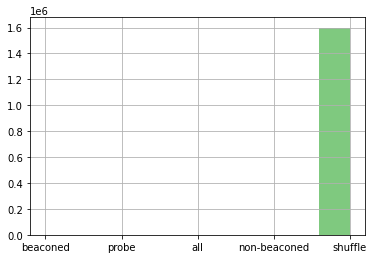

In [7]:
df_merged.dropna(inplace=True,subset=['fr_smooth'])
df_merged.trial_type.hist()

# concatenatenate the normal firing rate and the shuffled firing rate

### Peak analysis

In [52]:
out_range = np.arange(30//2,100//2) # from 30 to  100 cm, slightly beyond the reward zone x*2-30
home_range = np.arange(110//2,200//2) # 110 to 200, 0 to 30
all_range = np.arange(200//2)
print('out_range',pos[out_range])
print('home_range', pos[home_range])


dfs_agg_out_sel = peakAnalysis3(df_merged, out_range)
dfs_agg_home_sel = peakAnalysis3(df_merged, home_range)
dfs_agg_all_sel = peakAnalysis3(df_merged, all_range)

dfs_agg_out_sel.head()

out_range [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46
 48 50 52 54 56 58 60 62 64 66 68]
home_range [ 80  82  84  86  88  90  92  94  96  98 100 102 104 106 108 110 112 114
 116 118 120 122 124 126 128 130 132 134 136 138 140 142 144 146 148 150
 152 154 156 158 160 162 164 166 168]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1604138/1604138 [20:53<00:00, 1279.85it/s]


,session_id,cluster_id,trial_type,fr_smooth,pos,shuffle_id,extrema,extrema_cm,smooth_curve,extrema_type,min_cm,max_cm
8,245_D18_2018-11-10_11-07-50,9,beaconed,"[37.076238161899354, 40.022302504599494, 42.96...","[-30, -28, -26, -24, -22, -20, -18, -16, -14, ...",NaN,9,18,"[38.9914172772648, 38.9914172772648, 38.991417...",min,18,36
10,245_D18_2018-11-10_11-07-50,9,probe,"[49.68186442140235, 51.474931113789616, 53.267...","[-30, -28, -26, -24, -22, -20, -18, -16, -14, ...",NaN,29,58,"[37.36210263948584, 37.36210263948584, 37.3621...",max,14,58
11,245_D18_2018-11-10_11-07-50,9,all,"[38.07238622226296, 40.80894559859184, 43.5455...","[-30, -28, -26, -24, -22, -20, -18, -16, -14, ...",NaN,9,18,"[38.913065156596744, 38.913065156596744, 38.91...",min,18,32
8,245_D18_2018-11-10_11-07-50,13,beaconed,"[77.77794822745864, 81.84110696600222, 85.9042...","[-30, -28, -26, -24, -22, -20, -18, -16, -14, ...",NaN,0,0,"[126.87945905281389, 126.87945905281389, 126.8...",min,0,58
10,245_D18_2018-11-10_11-07-50,13,probe,"[127.7221562442304, 127.62600979009181, 127.52...","[-30, -28, -26, -24, -22, -20, -18, -16, -14, ...",NaN,13,26,"[141.51121253060373, 141.51121253060373, 141.5...",max,0,26


In [53]:
# combine dataframe together 
dfs_agg_out_sel['region'] = 'outbound'
dfs_agg_home_sel['region'] = 'homebound'
dfs_agg_all_sel['region'] = 'all'

dfs_comb = pd.concat([dfs_agg_out_sel, dfs_agg_home_sel,dfs_agg_all_sel])
dfs_comb.rename(columns={'ramp_region':'region'},inplace=True)
dfs_comb.head()

# merge lm classification
dfs_comb = dfs_comb.merge(df_lm,on=['session_id','cluster_id','trial_type','region'], how='left')
dfs_comb.classification.fillna('Unclassified',inplace=True)
dfs_comb['cell_id']=dfs_comb.session_id +':'+dfs_comb.cluster_id.astype('str')

In [54]:
dfs_comb.to_pickle(base_path+'ramp_peak_analysis.pkl')

### Plot figures

In [55]:
def setAxisLabel(ax,ylabel,xlabel=None,title=None):
    ax.set_ylabel(ylabel)
    if xlabel:
        ax.set_xlabel(xlabel)
    if title:
        ax.set_title(title)

<Figure size 2700x900 with 0 Axes>

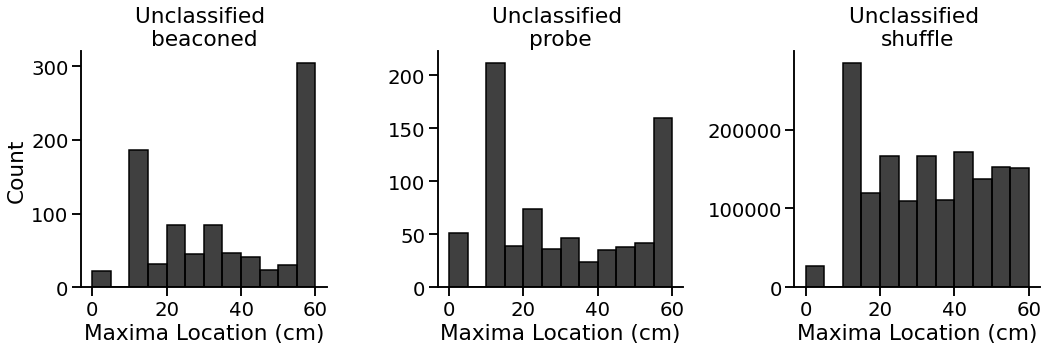

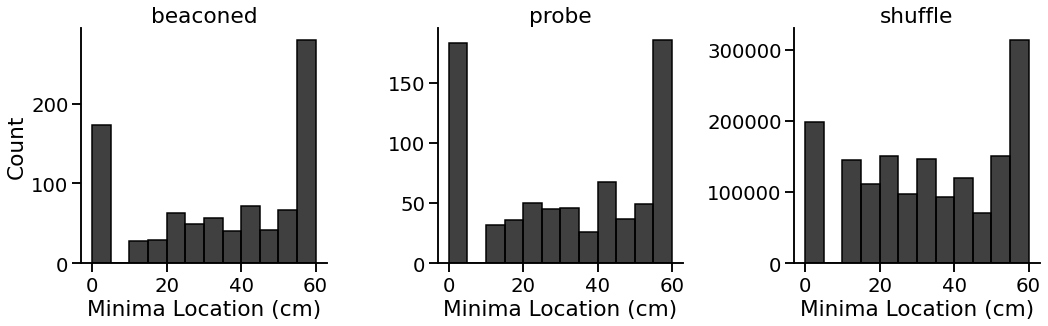

In [65]:
sns.set_context('talk',font_scale=1.2)

plt.figure(figsize=(3*3,3),dpi=300)

dfs2plot = dfs_comb[(dfs_comb.classification == 'Unclassified') &  (dfs_comb.region =='outbound') & (dfs_comb.trial_type.isin(['beaconed','probe', 'shuffle'])) ]
g = sns.displot(x='max_cm',col='trial_type', facet_kws={'sharey':False}, bins=12,  color='black', data=dfs2plot)
g.set_titles('Unclassified \n{col_name}')
g.set_axis_labels(x_var="Maxima Location (cm)")
plt.savefig('paper_figures/rampfigure_D_1.pdf',bbox_inches='tight')

g = sns.displot(x='min_cm',col='trial_type', facet_kws={'sharey':False,'sharex':False}, bins=12, color='black', data=dfs2plot)
g.set_titles('{col_name}')
g.set_axis_labels(x_var="Minima Location (cm)")
plt.savefig('paper_figures/rampfigure_D_2.pdf', bbox_inches='tight')

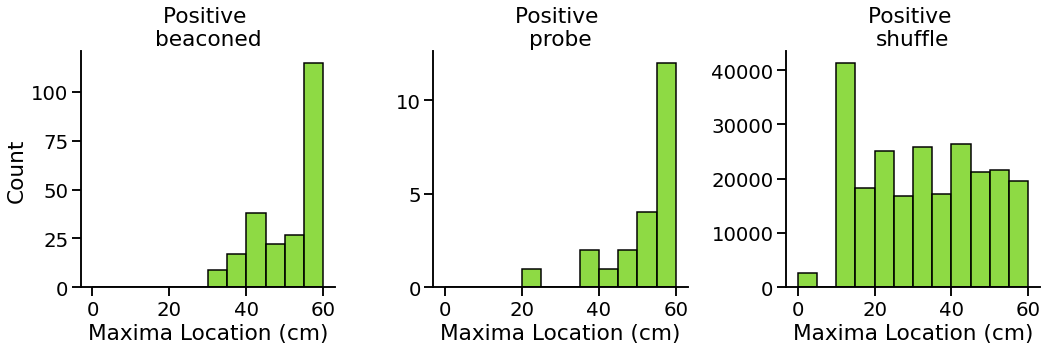

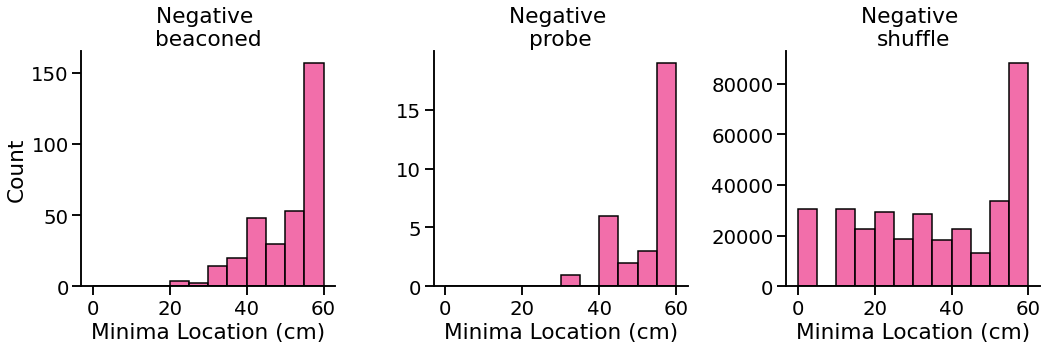

In [66]:
pos_color = '#69CE05'
neg_color = '#EE3E8E'

dfs2plot = dfs_comb[(dfs_comb.classification == 'Positive') & (dfs_comb.region =='outbound') & (dfs_comb.trial_type.isin(['beaconed','probe', 'shuffle'])) ]
df_shuffle2plot = dfs_comb[dfs_comb.cell_id.isin(dfs2plot.cell_id) & (dfs_comb.region=='outbound') &  (dfs_comb.trial_type=='shuffle')]
dfs2plot = pd.concat([dfs2plot,df_shuffle2plot]).reset_index()

g = sns.displot(x='max_cm',col='trial_type', facet_kws={'sharey':False}, bins=12, color=pos_color, data=dfs2plot)
g.set_titles('Positive \n{col_name}')
g.set_axis_labels(x_var="Maxima Location (cm)")
plt.savefig('paper_figures/rampfigure_E_1.pdf', bbox_inches='tight')

dfs2plot = dfs_comb[(dfs_comb.classification == 'Negative') &  (dfs_comb.region =='outbound') & (dfs_comb.trial_type.isin(['beaconed','probe', 'shuffle'])) ]
df_shuffle2plot = dfs_comb[dfs_comb.cell_id.isin(dfs2plot.cell_id) & (dfs_comb.region=='outbound') &  (dfs_comb.trial_type=='shuffle')]
dfs2plot = pd.concat([dfs2plot,df_shuffle2plot]).reset_index()

g = sns.displot(x='min_cm',col='trial_type', facet_kws={'sharey':False}, bins=12, color=neg_color, data=dfs2plot)
g.set_titles('Negative \n{col_name}')
g.set_axis_labels(x_var="Minima Location (cm)")
plt.savefig('paper_figures/rampfigure_E_2.pdf', bbox_inches='tight')

### Additional analysis

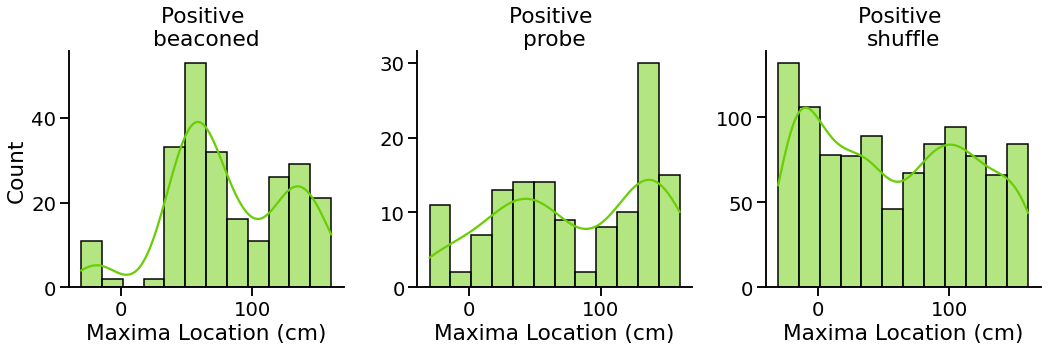

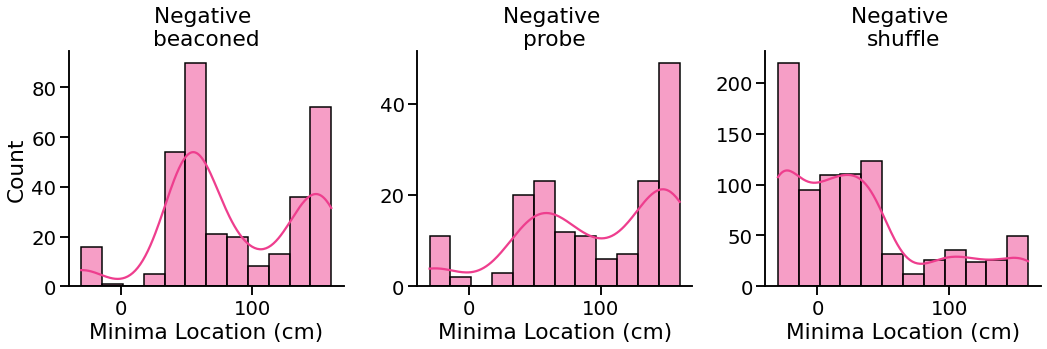

In [14]:
# of those cells that has a positive slope in outbound, where is the peak in the overall track?
pos_cells = dfs_comb[(dfs_comb.classification == 'Positive') &  (dfs_comb.region =='outbound') & (dfs_comb.trial_type.isin(['beaconed','probe', 'shuffle'])) ]
neg_cells = dfs_comb[(dfs_comb.classification == 'Negative') &  (dfs_comb.region =='outbound') & (dfs_comb.trial_type.isin(['beaconed','probe', 'shuffle'])) ]

full_track_cells = dfs_comb[(dfs_comb.region =='all') & (dfs_comb.trial_type.isin(['beaconed','probe', 'shuffle'])) ]

# match those in the full track
dfs2plot = full_track_cells[full_track_cells.cell_id.isin(pos_cells.cell_id)]

g = sns.displot(x='max_cm',col='trial_type', facet_kws={'sharey':False},kde=True, color=pos_color, data=dfs2plot)
g.set_titles('Positive \n{col_name}')
g.set_axis_labels(x_var="Maxima Location (cm)")

dfs2plot = full_track_cells[full_track_cells.cell_id.isin(neg_cells.cell_id)]

g = sns.displot(x='min_cm',col='trial_type', facet_kws={'sharey':False}, kde=True, color=neg_color, data=dfs2plot)
g.set_titles('Negative \n{col_name}')
g.set_axis_labels(x_var="Minima Location (cm)")